## 数据集和数据加载
处理数据样本的代码可能会变得混乱且难以维护;理想情况下，我们希望数据集代码与模型训练代码解耦，以获得更好的可读性和模块化。  
PyTorch提供了两个数据原语:torch.utils.data.DataLoader和torch.utils.data.Dataset，它们允许您使用预加载的数据集以及您自己的数据。  
数据集存储样本及其对应的标签，DataLoader围绕数据集包装了一个可迭代对象，以方便访问样本。  

PyTorch域库提供了许多预加载的数据集(如FashionMNIST)，它们是torch.util .data. dataset的子类，并实现特定于特定数据的函数。  
它们可以用于原型和基准测试你的模型。你可以在这里找到它们:图像数据集、文本数据集和音频数据集

## 加载数据集

In [3]:
# 下面是一个如何从TorchVision加载Fashion-MNIST数据集的例子。
# fashionmnist是Zalando文章图像的数据集，包含6万个训练示例和1万个测试示例。
# 每个示例包含28×28灰度图像和来自10个类之一的相关标签。
# 我们用以下参数加载FashionMNIST数据集:
# root 是列/测试数据存储的路径，
# train 指定训练或测试数据集，
# download=True 从互联网下载数据，如果它不在root下。
# transform和target_transform指定特征和标签转换

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=False,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=False,
    transform=ToTensor()
)

/Users/zhongshannan/opt/anaconda3/envs/Py38/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459044803/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## 迭代和可视化数据集

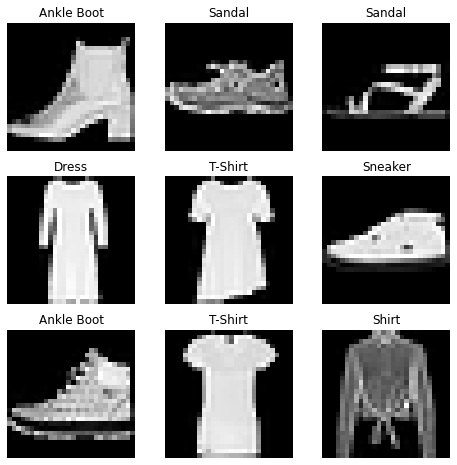

In [4]:
# 我们可以像列表一样手动索引数据集：training_data[index]。
# 我们使用 matplotlib 来可视化我们训练数据中的一些样本。

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols*rows+1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()  # 随机取样本索引
    img, label = training_data[sample_idx]  #根据随机索引取出图片、标签
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## 创建自定义数据集

In [5]:
# 自定义数据集类必须实现三个函数:__init__、__len__和__getitem__。
# FashionMNIST图像存储在目录img_dir中，它们的标签分别存储在CSV文件annotations_file中。

import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):

    # 初始化图像、注释文件、两种转换的目录
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.image_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    # __len__ 函数返回我们数据集中的样本数
    def __len__(self):
        return len(self.image_labels)
    
    # __getitem__函数从给定索引idx处的数据集加载并返回一个示例
    # 基于索引，它识别图像在磁盘上的位置，使用read_image将其转换为一个张量
    # 从self中的csv数据中检索相应的标签。Img_labels
    # 调用它们上的转换函数(如果适用的话)，并返回一个元组中的张量图像和相应的标签
    def __getitem__(self, idx):
        img_path =  os.path.join(self.img_dir, self.image_labels.iloc[idx, 0])
        image = read_image(img_path)  
        label = self.image_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

## 使用DataLoader为训练准备数据

数据集每次检索一个样本的数据集的特征和标签。在训练模型时，我们通常希望以“minibatches”传递样本，在每个epoch重新洗选数据以减少模型过拟合，并使用Python的多处理来加速数据检索。  

DataLoader是一个可迭代对象，它通过一个简单的API为我们抽象了这种复杂性。

In [6]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## 通过Dataloader进行迭代
我们已经将该数据集加载到DataLoader中，并可以根据需要遍历该数据集。  
下面的每次迭代都返回一批train_features和train_labels(分别包含batch_size=64个特征和标签)。  
因为我们指定了shuffle=True，所以在我们遍历所有批次之后，数据就会被打乱。

In [7]:
train_features, train_labels = next(iter(train_dataloader))  #遍历一个iter
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])
